In [22]:
import pandas as pd
import twint
from pytrends.request import TrendReq
pytrends = TrendReq(backoff_factor=0.5)
%run -i 'mod5_functions.py'
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
sns.set(style="ticks", context="talk")
plt.style.use("fivethirtyeight")
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import math
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import ttest_ind

In [2]:
# Using the get_int() function to retrieve the historical interest index for my key terms
indoor_farming_int = get_int('indoor farm', '2000-01-01 2020-05-18')
hydro_int = get_int('hydroponic', '2000-01-01 2020-05-18')
vertical_int = get_int('vertical farm', '2000-01-01 2020-05-18')
urban_ag_int = get_int('urban agriculture', '2000-01-01 2020-05-18')
aero_int = get_int('aeroponic', '2000-01-01 2020-05-18')
greenhaus_int = get_int('greenhouse', '2000-01-01 2020-05-18')

There are two ways I can go about this. I can turn this into a multivariate time series, where I use the VAR model, or I can use SARIMA(X) by averaging these indices together. Going to try the averaged way first.

In [4]:
# Going to average these series together to get a whole topic understanding
master = (aero_int['aeroponic']+urban_ag_int['urban agriculture']+vertical_int['vertical farm']+
          hydro_int['hydroponic']+indoor_farming_int['indoor farm']+
          greenhaus_int['greenhouse'])/6

In [5]:
# Going to turn this into a dataframe and change the index column name
master = master.to_frame()
master = rename_column(master, 0, 'interest')

In [74]:
# master.to_csv('remastered.csv')

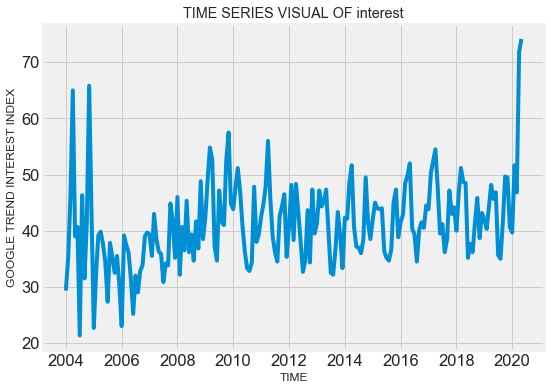

In [10]:
# Going to look at the time series plot
nice_plot(master, 'interest')

In [11]:
# Using a function to perform the Dicky Fuller Test
gen_dftest(master, 'interest')

Test Stat                -0.808468
P-Value                   0.816622
# Lags                   13.000000
# Observations          183.000000
Critical Value (1%)      -3.466598
Critical Value (5%)      -2.877467
Critical Value (10%)     -2.575260
dtype: float64

This time series is not stationary

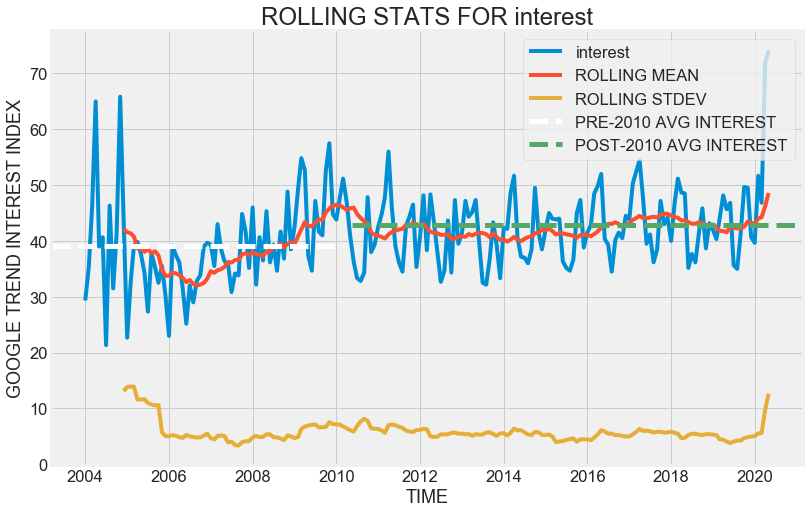

In [12]:
# Looking at the pre and post 2010 average interest index
# Looking at the rolling stats
rolling_stats(master, 'interest', 12)

In [15]:
# Testing the average interest score between the past decade and the current
# Want to see if they are statistically different
ttest_ind(master[:'2009']['interest'], master['2010':]['interest'], equal_var=False)

Ttest_indResult(statistic=-3.4595675943453306, pvalue=0.0007465550020896272)

Even though there seems to be some outlying data in the beginning, the p-value is still less than 0.05, which indicates to me that the average pre-2010 is significantly different than post-2010. And in this case, assuming the average pre-2010 is less.

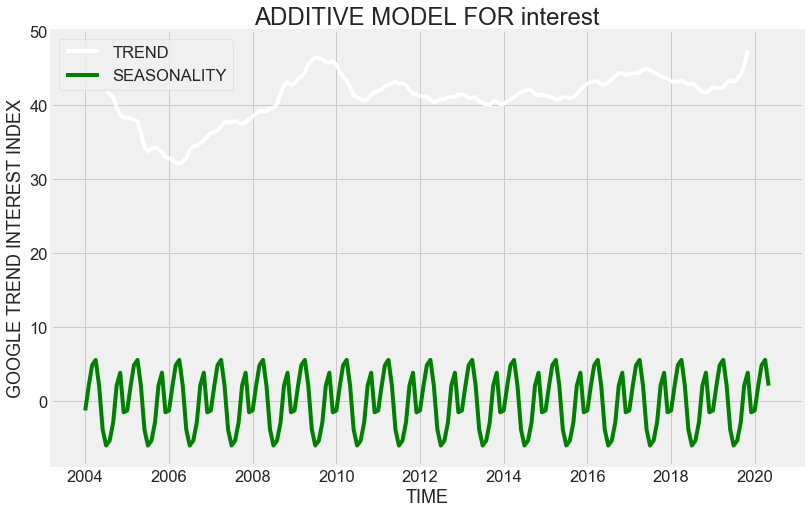

In [16]:
# Using a pre-defined function to look into the seasonal decomposition of the time series
# Uses statsmodels.tsa.seasonal.seasonal_decompose to accomplish
szn_decomp(master, 'interest', model=['additive'],
           graphs=['trend', 'szn'])

Seems to have an annual seasonality component. Interesting how it seems to peak just before year end and then again right after year end.

(<Figure size 1152x216 with 1 Axes>, <Figure size 1152x216 with 1 Axes>)

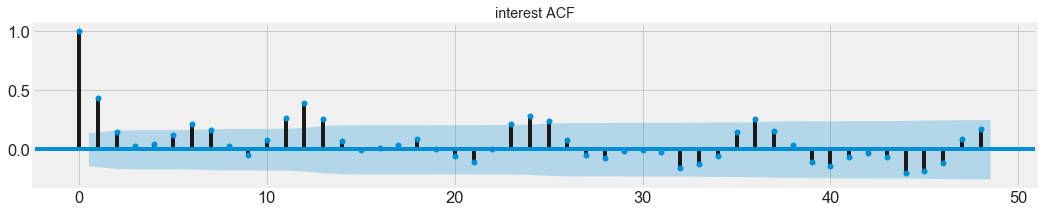

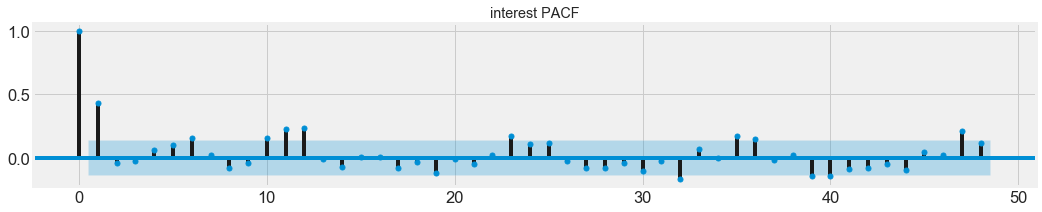

In [17]:
# Using pre-defined function to look into the ACF and PACF graphs
auto_corrs(master, 'interest')

More indication of a 12 month seasonality component

---

### Baseline Model

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:               interest   No. Observations:                  168
Model:                        SARIMAX   Log Likelihood                -863.119
Date:                Sat, 23 May 2020   AIC                           1728.237
Time:                        12:04:03   BIC                           1731.361
Sample:                    01-01-2004   HQIC                          1729.505
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1698.2326    744.074      2.282      0.022     239.874    3156.591
Ljung-Box (Q):                      180.98   Jarque-Bera (JB):                13.77
Prob(Q):                              0.00   Pr

,baseline model
AIC,1728.237032
BIC,1731.360996
MAE,40.602183
TRAIN RMSE,41.209618
TEST RMSE,46.271221


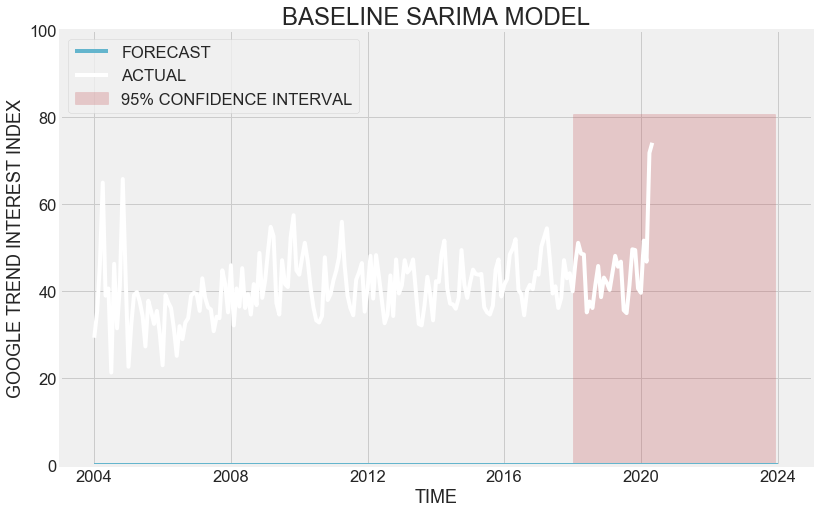

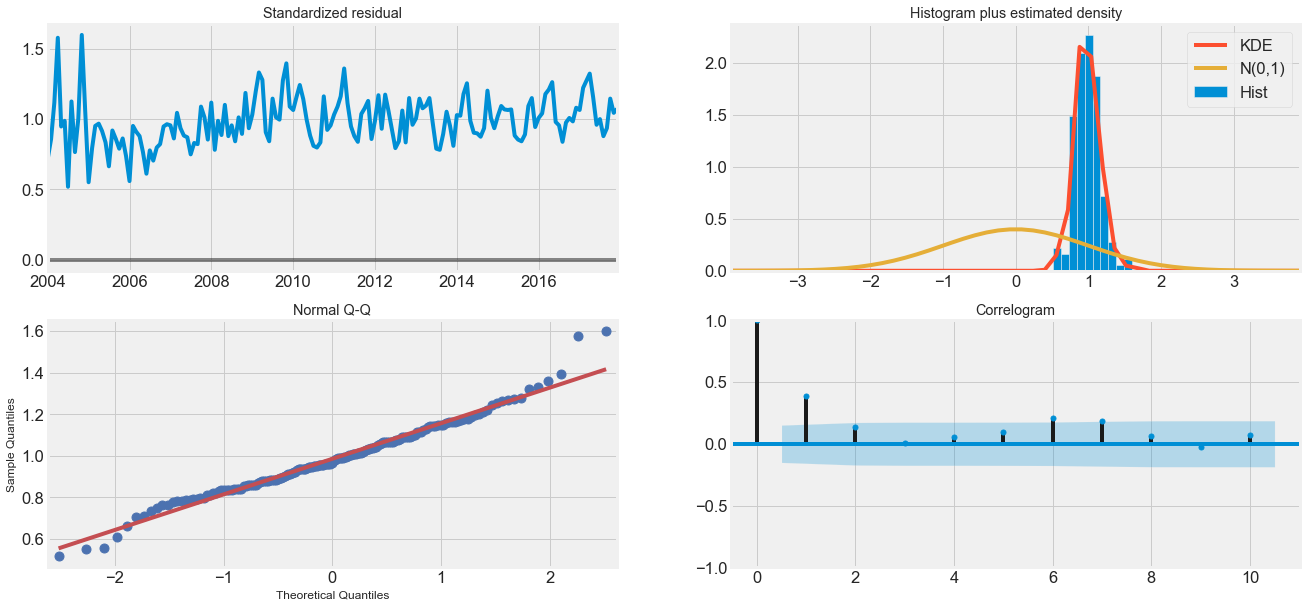

In [20]:
# Baseline SARIMA model with no ordering changes
# Just data by itself
baseline = SARIMAX(master['2004':'2017'], order=(0,0,0))
fit = baseline.fit()
print(fit.summary())
forecast = fit.predict(start='2004-01-01', end='2024-01-01')
print('\nForecasting 72 months into the future from the\ntraining data (2018 - 2024)\n.....\n....\n...\n..\n.')
forecast = pd.DataFrame(forecast)
forecast = rename_column(forecast, 0, 'forecast')
prediction = fit.get_forecast(steps=72)
pred_conf = prediction.conf_int()
# Plot the nice graphs
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(x=forecast.index, y=forecast['forecast'], color='c')
sns.lineplot(x=master['2004':].index,
             y=master['2004':]['interest'], color='w')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='r', alpha=0.25)
plt.legend(['FORECAST','ACTUAL', '95% CONFIDENCE INTERVAL'], loc='upper left')
plt.xlabel('TIME',size=18)
plt.ylabel('GOOGLE TREND INTEREST INDEX', size=18)
plt.ylim(0,100)
plt.title(f'BASELINE SARIMA MODEL', size=24)
baseline_scores = make_chart(fit, 'baseline model')
print(fit.plot_diagnostics(figsize=(20,10)))
baseline_scores

That didn't seem to forecast anything, so I am going to look into one order of differencing for my next model.

---

### Model 1 - employing one order of differencing

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:               interest   No. Observations:                  168
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -579.419
Date:                Sat, 23 May 2020   AIC                           1160.839
Time:                        12:12:48   BIC                           1163.957
Sample:                    01-01-2004   HQIC                          1162.104
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        60.4173      5.174     11.677      0.000      50.277      70.558
Ljung-Box (Q):                       83.69   Jarque-Bera (JB):                11.42
Prob(Q):                              0.00   Pr

,model 1
AIC,1160.838565
BIC,1163.956559
MAE,6.032738
TRAIN RMSE,8.073376
TEST RMSE,9.038339


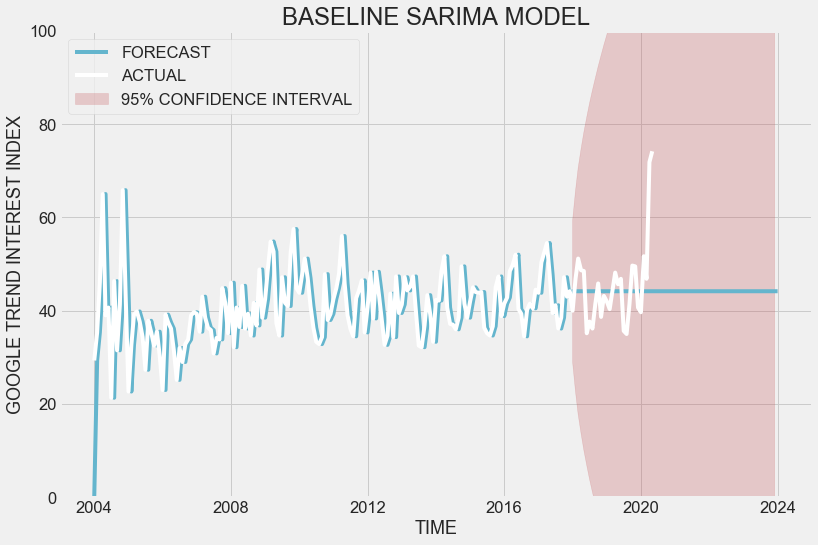

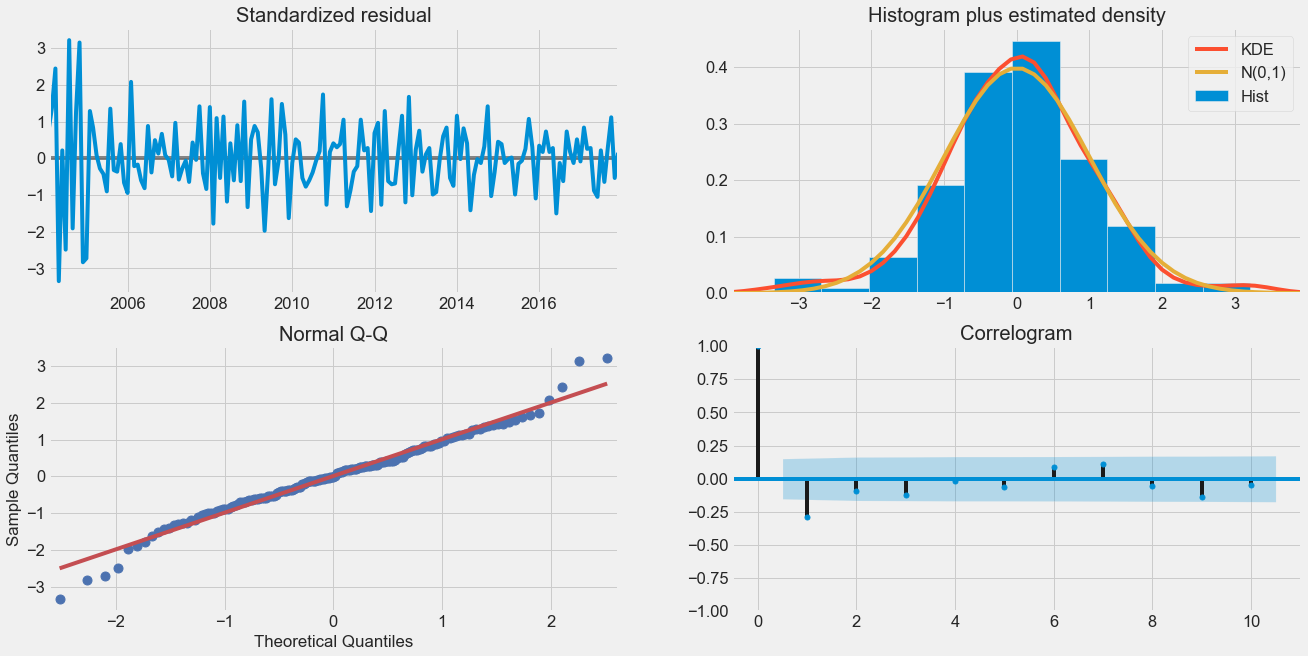

In [24]:
baseline = SARIMAX(master['2004':'2017'], order=(0,1,0))
fit = baseline.fit()
print(fit.summary())
forecast = fit.predict(start='2004-01-01', end='2024-01-01')
print('\nForecasting 72 months into the future from the\ntraining data (2018 - 2024)\n.....\n....\n...\n..\n.')
forecast = pd.DataFrame(forecast)
forecast = rename_column(forecast, 0, 'forecast')
prediction = fit.get_forecast(steps=72)
pred_conf = prediction.conf_int()
# Plot the nice graphs
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(x=forecast.index, y=forecast['forecast'], color='c')
sns.lineplot(x=master['2004':].index,
             y=master['2004':]['interest'], color='w')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='r', alpha=0.25)
plt.legend(['FORECAST','ACTUAL', '95% CONFIDENCE INTERVAL'], loc='upper left')
plt.xlabel('TIME',size=18)
plt.ylabel('GOOGLE TREND INTEREST INDEX', size=18)
plt.ylim(0,100)
plt.title('BASELINE SARIMA MODEL', size=24)
model_1_scores = make_chart(fit, 'model 1')
print(fit.plot_diagnostics(figsize=(20,10)))
model_1_scores

---

### Model 2 - employing one order of differencing, and one order of seasonal differencing with an **m value** = 12 for 12 month seasonality

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                           interest   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -550.560
Date:                            Sat, 23 May 2020   AIC                           1103.121
Time:                                    12:15:35   BIC                           1106.164
Sample:                                01-01-2004   HQIC                          1104.357
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        71.2484      7.670      9.289      0.000      56.215      86.282
Ljung-Box (Q):                     

,eda based model
AIC,1103.120616
BIC,1106.164041
MAE,7.529765
TRAIN RMSE,9.993097
TEST RMSE,7.402172


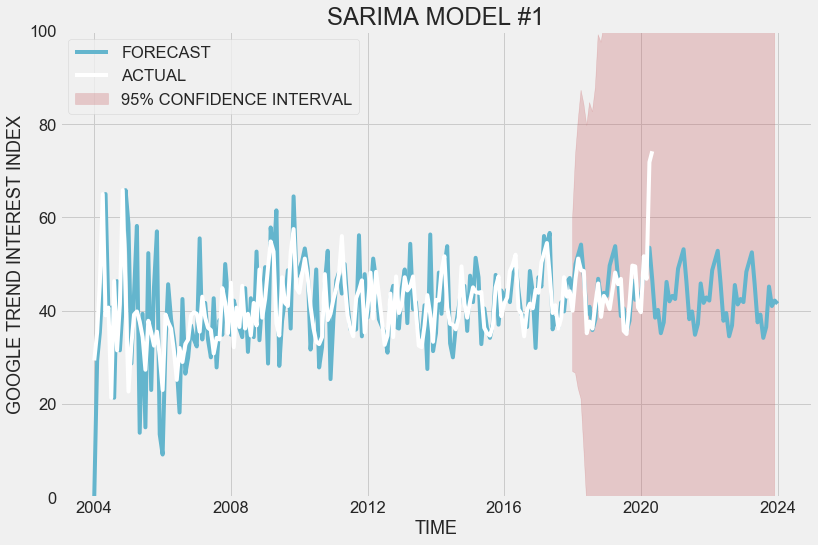

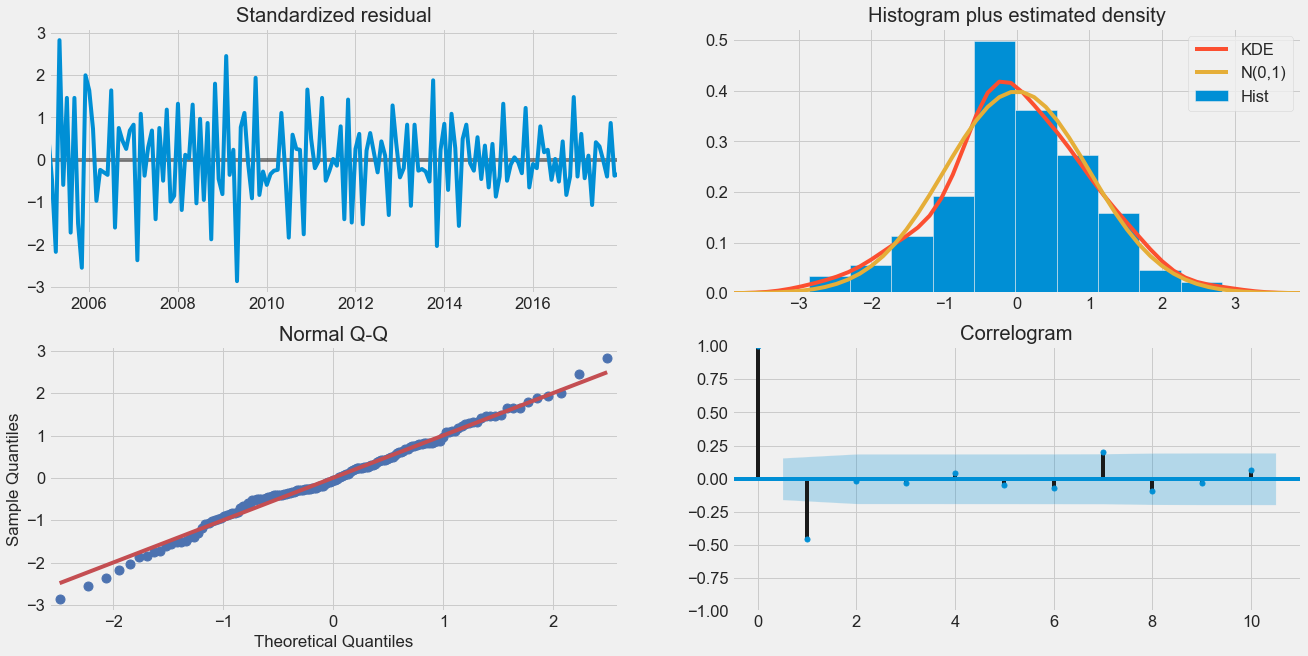

In [25]:
model = SARIMAX(master['2004':'2017'], order=(0,1,0), seasonal_order=(0, 1, 0, 12))
fit = model.fit()
print(fit.summary())
forecast = fit.predict(start='2004-01-01', end='2024-01-01')
print('\nForecasting 72 months into the future from the\ntraining data (2018 - 2024)\n.....\n....\n...\n..\n.')
forecast = pd.DataFrame(forecast)
forecast = rename_column(forecast, 0, 'forecast')
prediction = fit.get_forecast(steps=72)
pred_conf = prediction.conf_int()
# Plot the nice graphs
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(x=forecast.index, y=forecast['forecast'], color='c')
sns.lineplot(x=master['2004':].index,
             y=master['2004':]['interest'], color='w')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='r', alpha=0.25)
plt.legend(['FORECAST','ACTUAL', '95% CONFIDENCE INTERVAL'], loc='upper left')
plt.xlabel('TIME',size=18)
plt.ylabel('GOOGLE TREND INTEREST INDEX', size=18)
plt.ylim(0,100)
plt.title('SARIMA MODEL #1', size=24)
eda_based_model = make_chart(fit, 'eda based model')
print(fit.plot_diagnostics(figsize=(20,10)))
eda_based_model

---

## auto_arima Modeling  
Utilizing `auto_arima` to gridsearch through the best parameters for the ordering of the SARIMA model

### Auto Mod 1 - default setting of one order of differencing 

In [26]:
# Searching for best params
# I want the search to start from zero on the (pq) and (PQ) fronts
# Will be including default one order of differencing and seasonality
model = auto_arima(master['2004':'2017'], trace=True, start_p=0, start_q=0, d=1,
                  start_P=0, start_Q=0, seasonal=True, m=12, suppress_warnings=True, 
                   D=1, error_action='ignore', approximation=False, trend='t', random_state=42)
fitted = model.fit(master['2004':'2017'])

# auto_arima models have a .get_params method to get the best parameters based on AIC reduction
best_params = fitted.get_params()
print('\n\nThe best order parameters are {},{}\n'.format(best_params['order'],best_params['seasonal_order']))

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=1105.121, BIC=1111.207, Time=0.040 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=1059.337, BIC=1071.511, Time=0.306 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=1002.872, BIC=1015.046, Time=0.946 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=1105.121, BIC=1111.207, Time=0.026 seconds
Fit ARIMA(0,1,1)x(0,1,0,12) [intercept=True]; AIC=1035.779, BIC=1044.909, Time=0.177 seconds
Fit ARIMA(0,1,1)x(1,1,1,12) [intercept=True]; AIC=1008.837, BIC=1024.054, Time=1.125 seconds
Fit ARIMA(0,1,1)x(0,1,2,12) [intercept=True]; AIC=1006.256, BIC=1021.473, Time=2.728 seconds
Fit ARIMA(0,1,1)x(1,1,0,12) [intercept=True]; AIC=1019.269, BIC=1031.443, Time=0.772 seconds
Fit ARIMA(0,1,1)x(1,1,2,12) [intercept=True]; AIC=1003.570, BIC=1021.831, Time=3.206 seconds
Fit ARIMA(0,1,0)x(0,1,1,12) [intercept=True]; AIC=1079.400, BIC=1088.530, Time=0.491 seconds
Fit ARIMA(1,1,1)x(0,1,1,12

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                           interest   No. Observations:                  168
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -497.436
Date:                            Sat, 23 May 2020   AIC                           1002.872
Time:                                    12:20:59   BIC                           1015.046
Sample:                                01-01-2004   HQIC                          1007.817
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0001      0.001      0.198      0.843      -0.001       0.001
ma.L1         -0.8313      0.050   

,auto model 1
AIC,1002.871888
BIC,1015.045588
MAE,5.687009
TRAIN RMSE,8.373377
TEST RMSE,6.885236


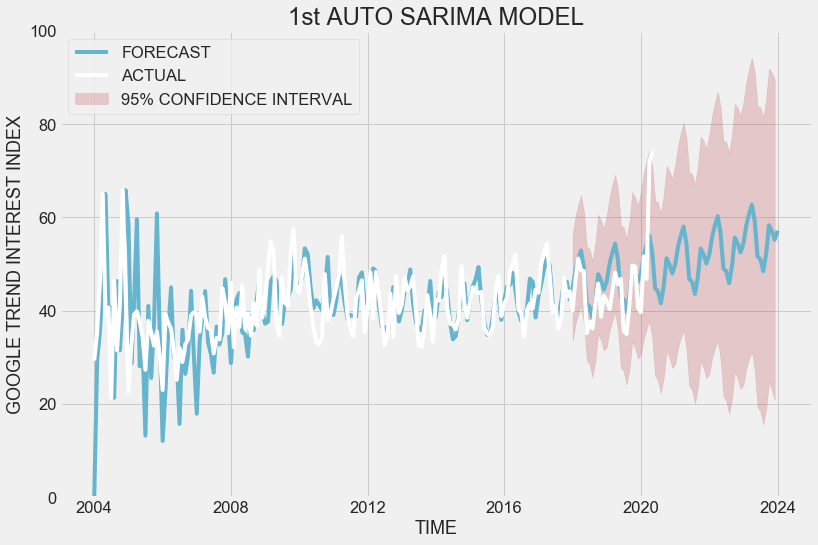

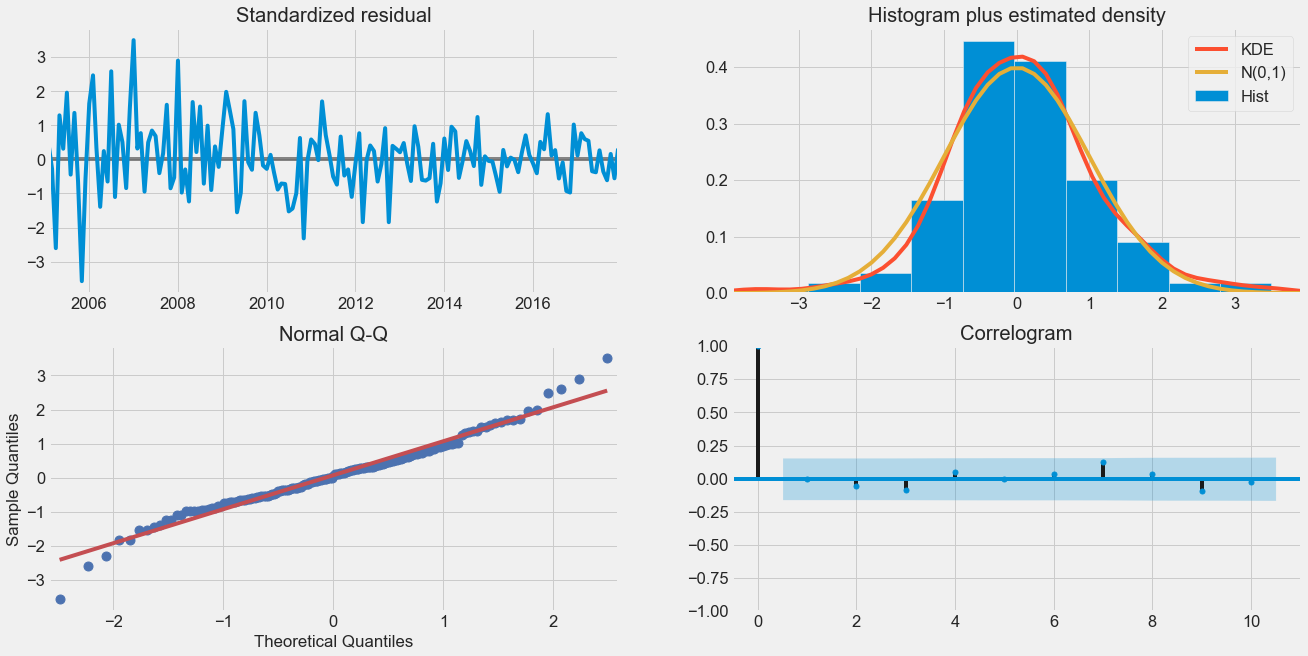

In [27]:
auto_mod1 = SARIMAX(master['2004':'2017'], order=(0,1,1), seasonal_order=(0,1,1,12),
                trend='t')
fit = auto_mod1.fit()
print(fit.summary())
forecast = fit.predict(start='2004-01-01', end='2024-01-01')
print('\nForecasting 72 months into the future from the\ntraining data (2018 - 2024)\n.....\n....\n...\n..\n.')
forecast = pd.DataFrame(forecast)
forecast = rename_column(forecast, 0, 'forecast')
prediction = fit.get_forecast(steps=72)
pred_conf = prediction.conf_int()
# Plot the nice graphs
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(x=forecast.index, y=forecast['forecast'], color='c')
sns.lineplot(x=master['2004':].index,
             y=master['2004':]['interest'], color='w')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='r', alpha=0.25)
plt.legend(['FORECAST','ACTUAL', '95% CONFIDENCE INTERVAL'], loc='upper left')
plt.xlabel('TIME',size=18)
plt.ylabel('GOOGLE TREND INTEREST INDEX', size=18)
plt.ylim(0,100)
plt.title('1st AUTO SARIMA MODEL', size=24)

auto_mod_1 = make_chart(fit, 'auto model 1')
print(fit.plot_diagnostics(figsize=(20,10)))
auto_mod_1

---

### Auto Mod 2 - includes no default setting for differencing

In [28]:
model = auto_arima(master['2004':'2017'], trace=True, start_p=0, start_q=0,
                  start_P=0, start_Q=0, seasonal=True, m=12, suppress_warnings=True,
                   error_action='ignore', approximation=False, trend='t', random_state=42)
fitted = model.fit(master['2004':'2017'])
best_params = fitted.get_params()
print('\n\nThe best order parameters are {},{}\n'.format(best_params['order'],best_params['seasonal_order']))

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=1162.835, BIC=1169.071, Time=0.062 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=1125.529, BIC=1138.001, Time=0.119 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=1097.136, BIC=1109.608, Time=0.442 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=1162.835, BIC=1169.071, Time=0.046 seconds
Fit ARIMA(0,1,1)x(0,0,0,12) [intercept=True]; AIC=1120.285, BIC=1129.639, Time=0.295 seconds
Fit ARIMA(0,1,1)x(1,0,1,12) [intercept=True]; AIC=1078.415, BIC=1094.005, Time=0.748 seconds
Fit ARIMA(0,1,1)x(1,0,0,12) [intercept=True]; AIC=1087.757, BIC=1100.229, Time=0.416 seconds
Fit ARIMA(0,1,1)x(2,0,1,12) [intercept=True]; AIC=1076.666, BIC=1095.374, Time=1.522 seconds
Fit ARIMA(0,1,1)x(2,0,0,12) [intercept=True]; AIC=1085.053, BIC=1100.643, Time=1.967 seconds
Fit ARIMA(0,1,1)x(2,0,2,12) [intercept=True]; AIC=1074.751, BIC=1096.577, Time=2.344 seconds
Fit ARIMA(0,1,1)x(1,0,2,12

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                        SARIMAX Results                                        
Dep. Variable:                                interest   No. Observations:                  168
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                -530.375
Date:                                 Sat, 23 May 2020   AIC                           1074.751
Time:                                         12:24:46   BIC                           1096.577
Sample:                                     01-01-2004   HQIC                          1083.609
                                          - 12-01-2017                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0002      0.001      0.339      0.735      -0.001       0

,auto model 2
AIC,1074.750787
BIC,1096.576744
MAE,4.568103
TRAIN RMSE,6.597608
TEST RMSE,7.109907


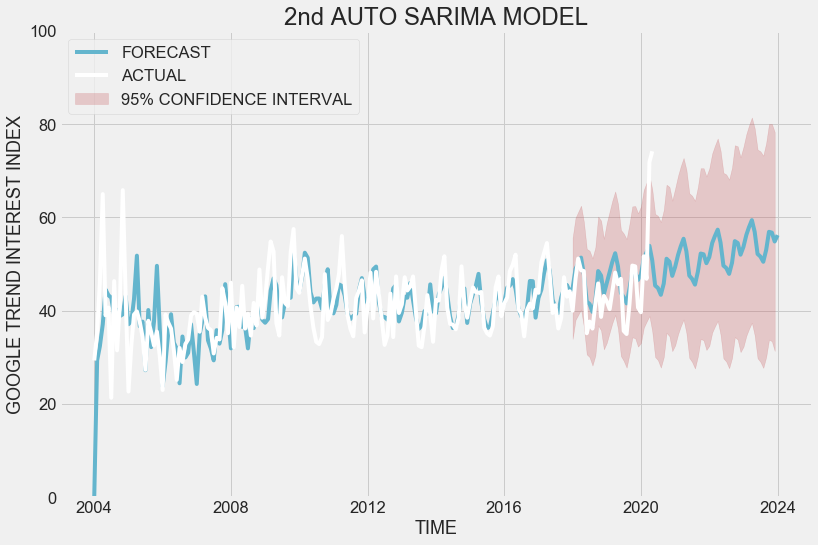

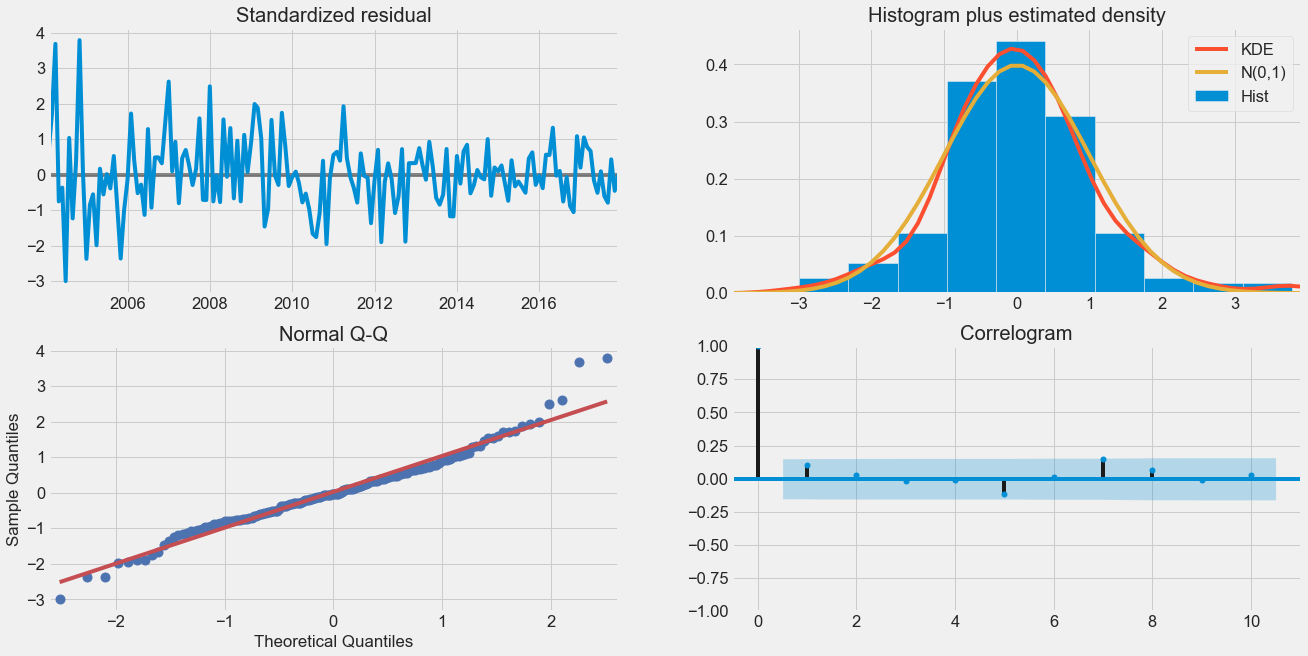

In [29]:
auto_mod2 = SARIMAX(master['2004':'2017'], order=(0,1,1), seasonal_order=(2,0,2,12),
                trend='t')
fit = auto_mod2.fit()
print(fit.summary())
forecast = fit.predict(start='2004-01-01', end='2024-01-01')
print('\nForecasting 72 months into the future from the\ntraining data (2018 - 2024)\n.....\n....\n...\n..\n.')
forecast = pd.DataFrame(forecast)
forecast = rename_column(forecast, 0, 'forecast')
prediction = fit.get_forecast(steps=72)
pred_conf = prediction.conf_int()
# Plot the nice graphs
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(x=forecast.index, y=forecast['forecast'], color='c')
sns.lineplot(x=master['2004':].index,
             y=master['2004':]['interest'], color='w')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='r', alpha=0.25)
plt.legend(['FORECAST','ACTUAL', '95% CONFIDENCE INTERVAL'], loc='upper left')
plt.xlabel('TIME',size=18)
plt.ylabel('GOOGLE TREND INTEREST INDEX', size=18)
plt.ylim(0,100)
plt.title('2nd AUTO SARIMA MODEL', size=24)

auto_mod_2 = make_chart(fit, 'auto model 2')
print(fit.plot_diagnostics(figsize=(20,10)))
auto_mod_2

---

### Auto Mod 3 - no specified starting parameter settings, using 'bfgs' solver

In [31]:
# Note that I have removed the starting parameters specifications
# Going to try the different methods
# model = auto_arima(master['2004':'2017'], trace=True, seasonal=True, m=12, suppress_warnings=True,
#                 error_action='ignore', approximation=False, trend='t', method='bfgs', random_state=42)
# fitted = model.fit(master['2004':'2017'])
best_params = fitted.get_params()
print('\n\nThe best order parameters are {},{}\n'.format(best_params['order'],best_params['seasonal_order']))



The best order parameters are (0, 1, 1),(1, 0, 1, 12)



/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                           interest   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -535.553
Date:                            Sat, 23 May 2020   AIC                           1083.106
Time:                                    12:30:22   BIC                           1101.814
Sample:                                01-01-2004   HQIC                          1090.699
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0002      0.000      0.423      0.672      -0.001       0.001
ar.L1          0.2057      0.078   

,auto model 3
AIC,1083.106171
BIC,1101.814134
MAE,4.701234
TRAIN RMSE,6.628161
TEST RMSE,7.760085


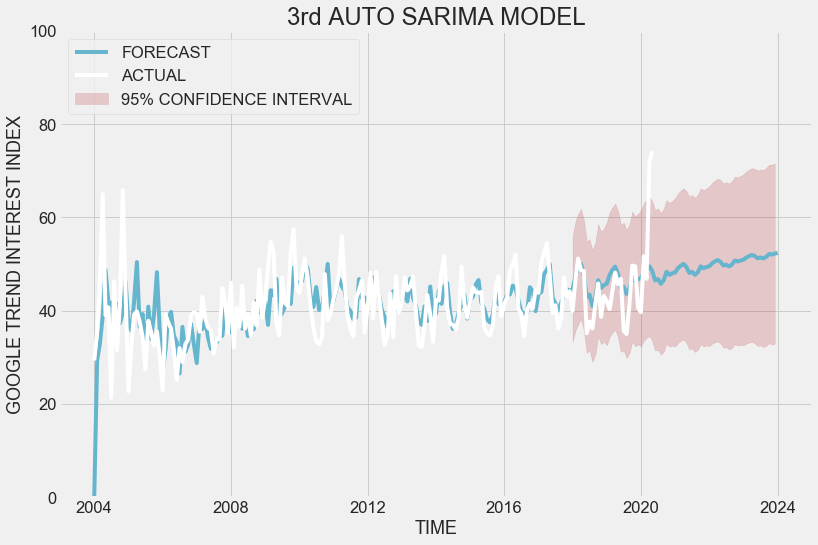

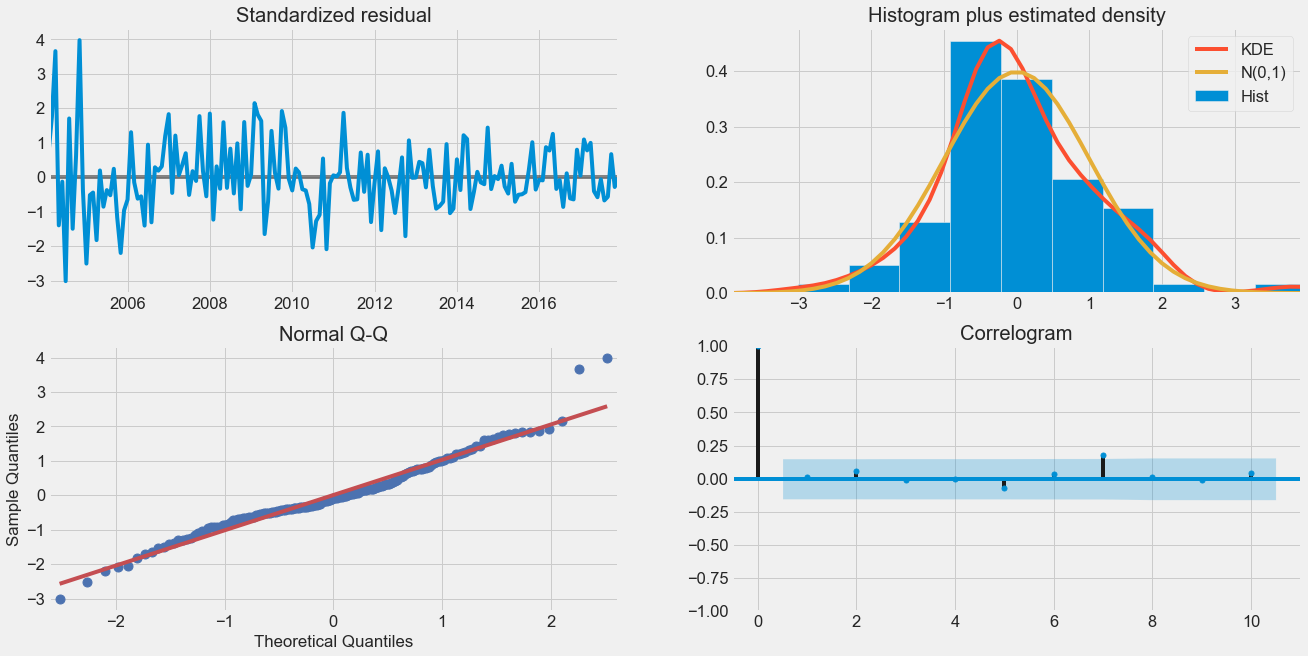

In [32]:
auto_mod3 = SARIMAX(master['2004':'2017'], order=(1,1,1), seasonal_order=(1,0,1,12),
                trend='t')
fit = auto_mod3.fit()
print(fit.summary())
forecast = fit.predict(start='2004-01-01', end='2024-01-01')
print('\nForecasting 72 months into the future from the\ntraining data (2018 - 2024)\n.....\n....\n...\n..\n.')
forecast = pd.DataFrame(forecast)
forecast = rename_column(forecast, 0, 'forecast')
prediction = fit.get_forecast(steps=72)
pred_conf = prediction.conf_int()
# Plot the nice graphs
fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(x=forecast.index, y=forecast['forecast'], color='c')
sns.lineplot(x=master['2004':].index,
             y=master['2004':]['interest'], color='w')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='r', alpha=0.25)
plt.legend(['FORECAST','ACTUAL', '95% CONFIDENCE INTERVAL'], loc='upper left')
plt.xlabel('TIME',size=18)
plt.ylabel('GOOGLE TREND INTEREST INDEX', size=18)
plt.ylim(0,100)
plt.title('3rd AUTO SARIMA MODEL', size=24)
auto_mod_3 = make_chart(fit, 'auto model 3')
print(fit.plot_diagnostics(figsize=(20,10)))
auto_mod_3

---

### Auto Mod 4 - same as before, using powell solver

In [33]:
# Trying the powell optimizer
model = auto_arima(master['2004':'2017'], trace=True, seasonal=True, m=12, suppress_warnings=True,
                error_action='ignore', approximation=False, trend='t', method='powell', random_state=42)
fitted = model.fit(master['2004':'2017'])
best_params = fitted.get_params()
print('\n\nThe best order parameters are {},{}\n'.format(best_params['order'],best_params['seasonal_order']))

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=1080.257, BIC=1105.201, Time=1.240 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=1162.835, BIC=1169.071, Time=0.031 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=1125.529, BIC=1138.001, Time=0.228 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=1097.136, BIC=1109.608, Time=0.153 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=1162.835, BIC=1169.071, Time=0.026 seconds
Fit ARIMA(2,1,2)x(0,0,1,12) [intercept=True]; AIC=1089.162, BIC=1110.988, Time=0.583 seconds
Near non-invertible roots for order (2, 1, 2)(0, 0, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(2,1,2)x(1,0,0,12) [intercept=True]; AIC=1085.897, BIC=1107.723, Time=0.735 seconds
Near non-invertible roots for order (2, 1, 2)(1, 0, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit ci

Seen these parameters before, going to skip over this one in my analysis and only use the original model with these parameters in order to not have duplicates.

---

### Auto Mod 5 - using same settings as before, but with default 'lbfgs' solver

In [34]:
model = auto_arima(master['2004':'2017'], trace=True, seasonal=True, m=12, suppress_warnings=True,
                error_action='ignore', approximation=False, trend='t', random_state=42)
fitted = model.fit(master['2004':'2017'])
best_params = fitted.get_params()
print('\n\nThe best order parameters are {},{}\n'.format(best_params['order'],best_params['seasonal_order']))

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=1088.031, BIC=1112.975, Time=0.956 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=1162.835, BIC=1169.071, Time=0.039 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=1125.529, BIC=1138.001, Time=0.114 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=1097.136, BIC=1109.608, Time=0.524 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=1162.835, BIC=1169.071, Time=0.049 seconds
Fit ARIMA(2,1,2)x(0,0,1,12) [intercept=True]; AIC=1089.353, BIC=1111.179, Time=0.693 seconds
Near non-invertible roots for order (2, 1, 2)(0, 0, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA(2,1,2)x(1,0,0,12) [intercept=True]; AIC=1087.053, BIC=1108.879, Time=0.831 seconds
Near non-invertible roots for order (2, 1, 2)(1, 0, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit ci

Another repeat.

---

## Final Model Parameters to Compare

* baseline - (0,0,0)x(0,0,0,0)  
* model 1 - (0,1,0)x(0,0,0,0)  
* model 2 - (0,1,0)x(0,1,0,12)
* auto model 1 - (0,1,1)x(0,1,1,12)  
* auto model 2 - (0,1,1)x(2,0,2,12)
* auto model 3 - (1,1,1)x(1,0,1,12)

In [54]:
aic = compare_scores('AIC', [baseline_scores,model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
bic = compare_scores('BIC', [baseline_scores,model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
mae = compare_scores('MAE', [baseline_scores,model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
train_rmse = compare_scores('TRAIN RMSE', [baseline_scores,model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
test_rmse = compare_scores('TEST RMSE', [baseline_scores,model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
metrics = [aic, bic, mae, train_rmse, test_rmse]

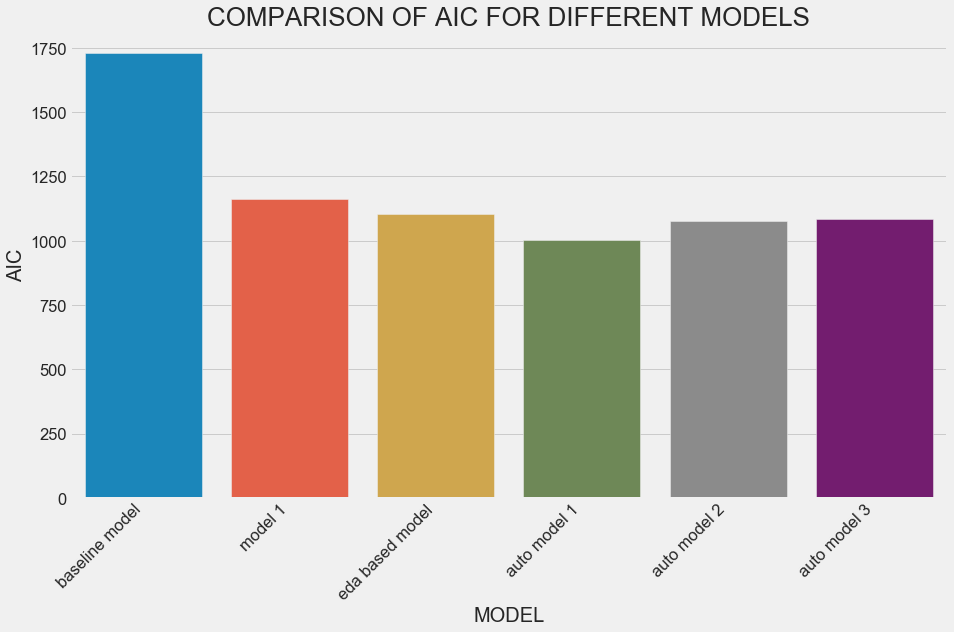

In [37]:
score_chart(list(aic.keys()), list(aic.values()), 'AIC')

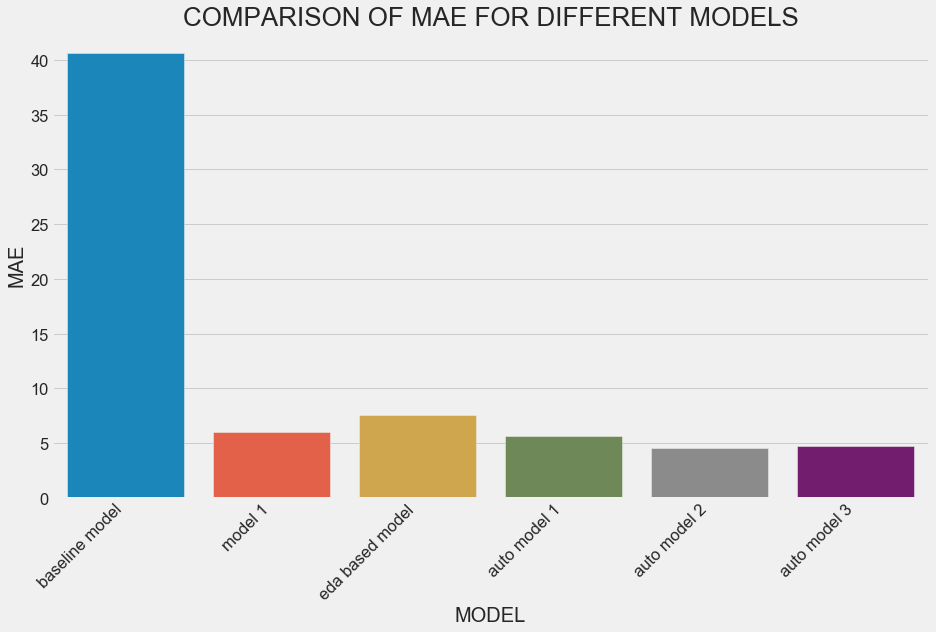

In [38]:
score_chart(list(mae.keys()), list(mae.values()),'MAE')

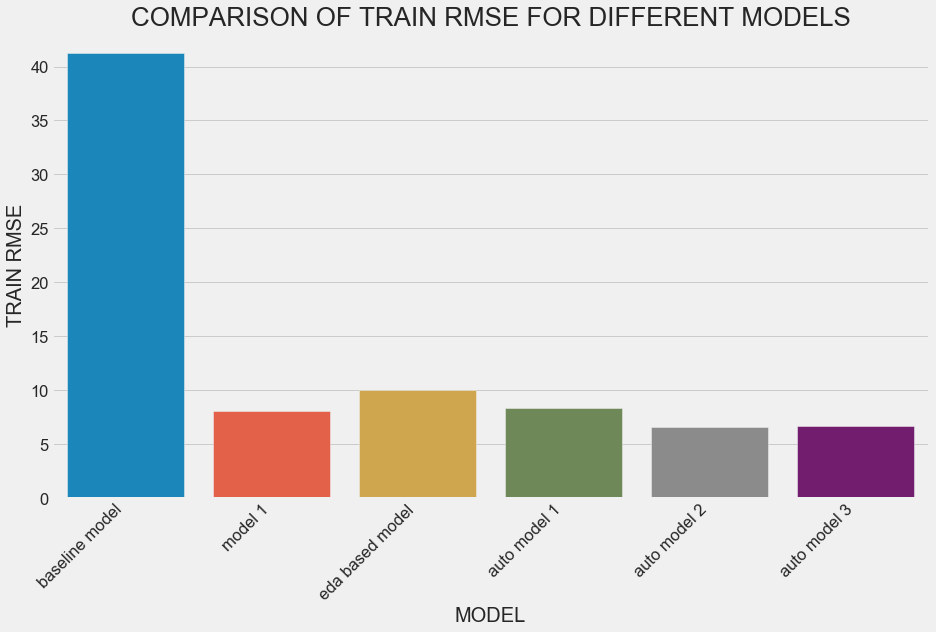

In [39]:
score_chart(list(train_rmse.keys()), list(train_rmse.values()), 'TRAIN RMSE')

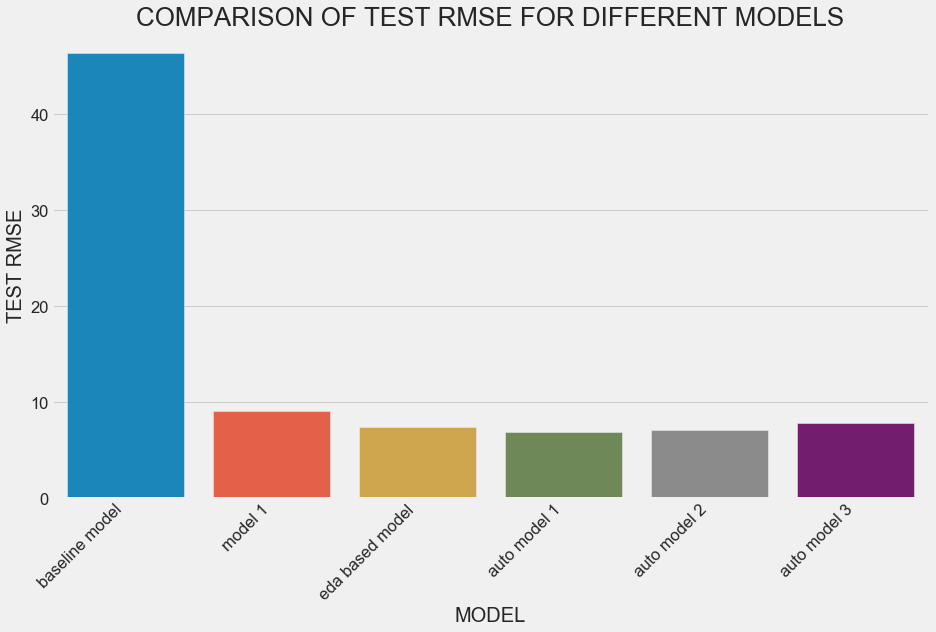

In [40]:
score_chart(list(test_rmse.keys()), list(test_rmse.values()), 'TEST RMSE')

Clearly all models performed much better than the baseline. I want to see what the breakdown looks like without the baseline affecting the y-axis scale.

In [41]:
aic = compare_scores('AIC', [model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
bic = compare_scores('BIC', [model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
mae = compare_scores('MAE', [model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
train_rmse = compare_scores('TRAIN RMSE', [model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
test_rmse = compare_scores('TEST RMSE', [model_1_scores, eda_based_model, auto_mod_1, auto_mod_2,
                            auto_mod_3])
metrics = [aic, bic, mae, train_rmse, test_rmse]

In [51]:
aic

{'model 1': 1160.838565006834,
 'eda based model': 1103.1206157488737,
 'auto model 1': 1002.8718877930577,
 'auto model 2': 1074.7507871146486,
 'auto model 3': 1083.1061708204545}

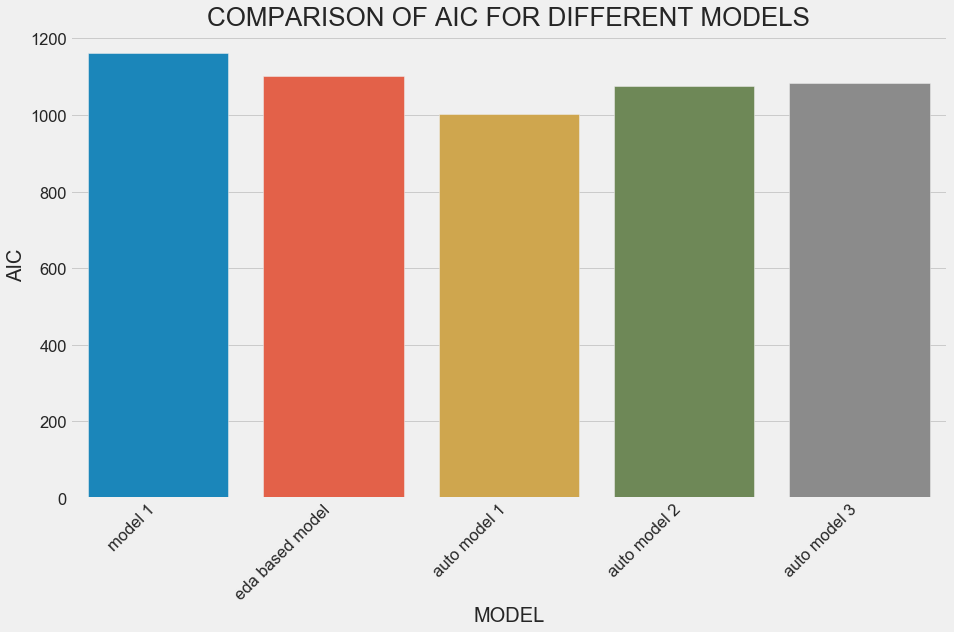

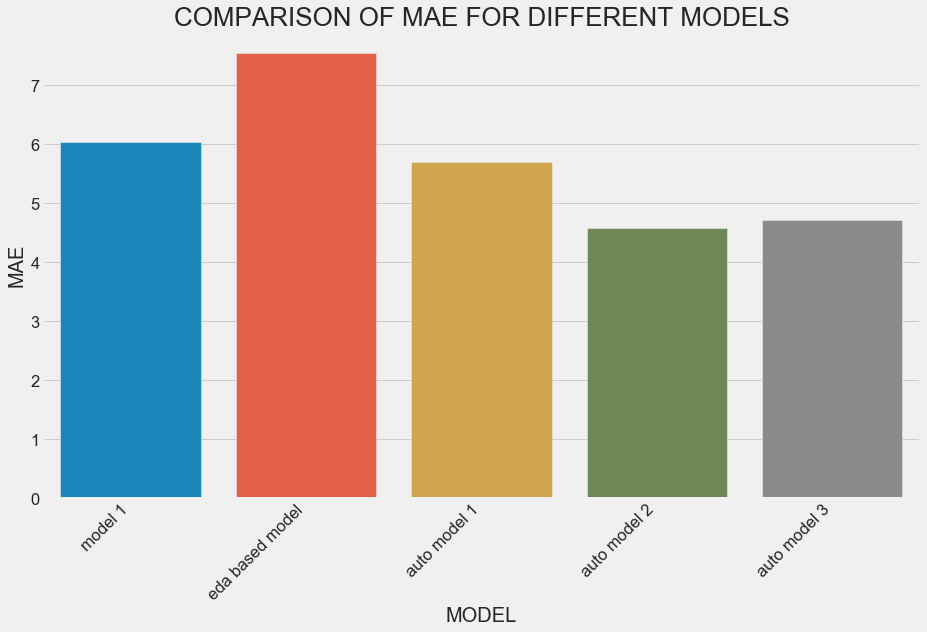

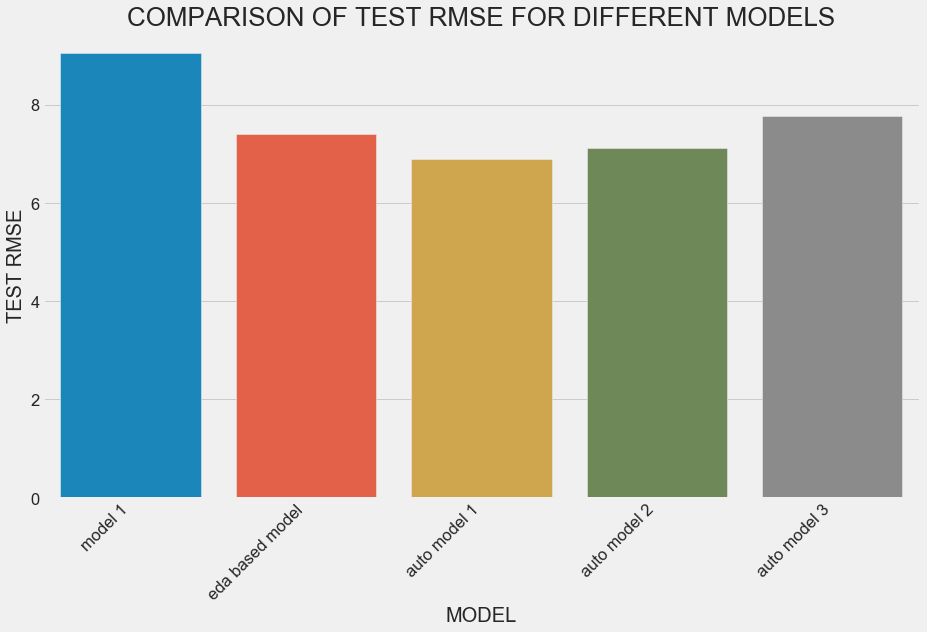

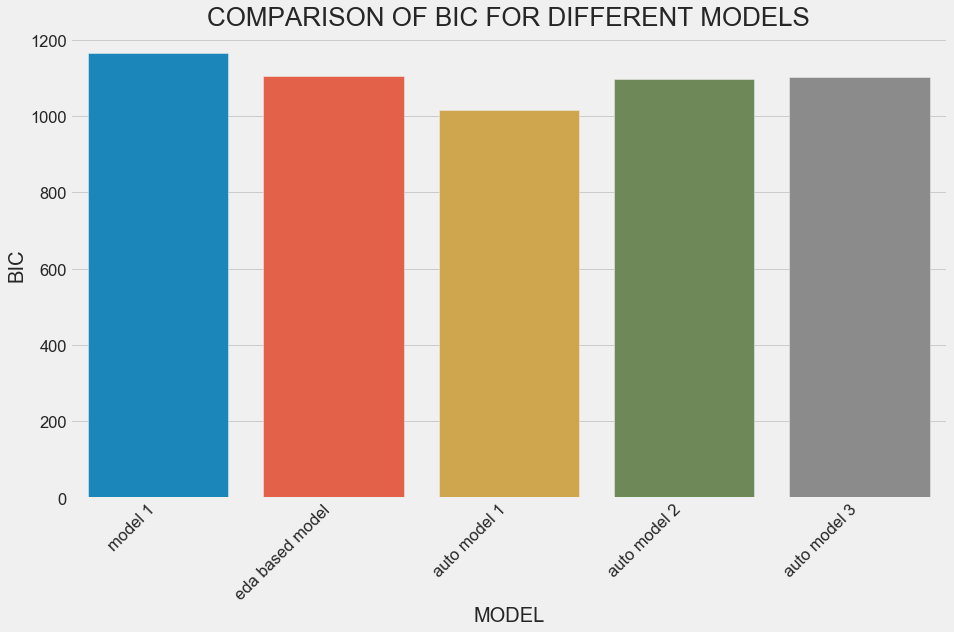

In [43]:
score_chart(list(aic.keys()), list(aic.values()), 'AIC')
score_chart(list(mae.keys()), list(mae.values()),'MAE')
score_chart(list(test_rmse.keys()), list(test_rmse.values()), 'TEST RMSE')
score_chart(list(bic.keys()), list(bic.values()), 'BIC')

The first auto model has captured 3/4 wins for the evaluation metrics. AIC, BIC, and Test RMSE. It lost out on the MAE, but was still better than model 1 and eda based model.

---

### Evaluation Metrics Analysis

Going to calculate the percent improvement over one model to another. Going to make this somewhat open ended so I can look at differences between different models. I want to look into the improvements over baseline first, then look at the improvements over model 1, then eda model.

In [67]:
def compare_models(model1, model2, mod1_title, mod2_title):
        aic_pc = ((aic[model2]-aic[model1])/aic[model1])*100
        bic_pc = ((bic[model2]-bic[model1])/bic[model1])*100
        mae_pc = ((mae[model2]-mae[model1])/mae[model1])*100
        test_rmse_pc = ((test_rmse[model2]-test_rmse[model1])/test_rmse[model1])*100
        print('The percent improvements from {} to {},\n where a stronger negative number relates to increased improvment,\n are the following: \n'.format(mod1_title, mod2_title))
        print('AIC Improvements: ',aic_pc,'\n',
              'BIC Improvements: ',bic_pc,'\n',
              'MAE Improvments: ',mae_pc,'\n',
              'Test RMSE Improvements: ',test_rmse_pc)
    

In [69]:
aic

{'baseline model': 1728.237032489746,
 'model 1': 1160.838565006834,
 'eda based model': 1103.1206157488737,
 'auto model 1': 1002.8718877930577,
 'auto model 2': 1074.7507871146486,
 'auto model 3': 1083.1061708204545}

In [68]:
compare_models('baseline model', 'model 1', 'BASELINE MODEL', 'MODEL 1')


The percent improvements from BASELINE MODEL to MODEL 1,
 where a stronger negative number relates to increased improvment,
 are the following: 

AIC Improvements:  -32.83105597300518 
 BIC Improvements:  -32.77216240905477 
 MAE Improvments:  -85.14183790651639 
 Test RMSE Improvements:  -80.46660793814317


In [70]:
compare_models('baseline model', 'eda based model', 'BASELINE MODEL', 'EDA BASED MODEL')

The percent improvements from BASELINE MODEL to EDA BASED MODEL,
 where a stronger negative number relates to increased improvment,
 are the following: 

AIC Improvements:  -36.170756961521214 
 BIC Improvements:  -36.110144382272196 
 MAE Improvments:  -81.45477768999986 
 Test RMSE Improvements:  -84.00264446425794


In [71]:
compare_models('baseline model', 'auto model 1', 'BASELINE MODEL', 'AUTO MODEL 1')

The percent improvements from BASELINE MODEL to AUTO MODEL 1,
 where a stronger negative number relates to increased improvment,
 are the following: 

AIC Improvements:  -41.97139229517072 
 BIC Improvements:  -41.37296668165867 
 MAE Improvments:  -85.99334108374643 
 Test RMSE Improvements:  -85.11983039770057


In [72]:
compare_models('baseline model', 'auto model 2', 'BASELINE MODEL', 'AUTO MODEL 2')

The percent improvements from BASELINE MODEL to AUTO MODEL 2,
 where a stronger negative number relates to increased improvment,
 are the following: 

AIC Improvements:  -37.81230427828914 
 BIC Improvements:  -36.66388777165077 
 MAE Improvments:  -88.74911924620027 
 Test RMSE Improvements:  -84.63427863252124


In [73]:
compare_models('baseline model', 'auto model 3', 'BASELINE MODEL', 'AUTO MODEL 3')

The percent improvements from BASELINE MODEL to AUTO MODEL 3,
 where a stronger negative number relates to increased improvment,
 are the following: 

AIC Improvements:  -37.32884144600803 
 BIC Improvements:  -36.36138645020077 
 MAE Improvments:  -88.42122722500832 
 Test RMSE Improvements:  -83.22913263402899
